# Visualizations for Embeddings

In [ ]:
# Note: you may need to restart the kernel to use updated packages.
%pip install --upgrade whylogs[embeddings,viz]

In [1]:
import whylogs as why

why.__version__

'1.1.34'

In [2]:
import os
import pickle
from sklearn.datasets import fetch_openml

if os.path.exists("/home/bernease/.datasets/mnist_784_X_y.pkl"):
    print("Dataset found.")
    X, y = pickle.load(open("/home/bernease/.datasets/mnist_784_X_y.pkl", 'rb'))
else:
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

Dataset found.


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_prod, y_train, y_prod = train_test_split(X, y, test_size=0.1)

In [4]:
from whylogs.experimental.preprocess.embeddings.selectors import PCACentroidsSelector

references, labels = PCACentroidsSelector(n_components=20).calculate_references(X_train, y_train)

In [5]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
from whylogs.experimental.preprocess.embeddings.selectors import PCAKMeansSelector

unsup_references, unsup_labels = PCAKMeansSelector(n_clusters=8, n_components=20).calculate_references(X_train, y_train)

PCAKMeansSelector is unsupervised; ignoring labels
/home/bernease/whylabs/repos/whylogs/python/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
import whylogs as why
from whylogs.core.resolvers import MetricSpec, ResolverSpec
from whylogs.core.schema import DeclarativeSchema
from whylogs.experimental.extras.embedding_metric import (
    DistanceFunction,
    EmbeddingConfig,
    EmbeddingMetric,
)

config = EmbeddingConfig(
    references=references,
    labels=labels,
    distance_fn=DistanceFunction.euclidean,
)
schema = DeclarativeSchema([ResolverSpec(column_name="pixel_values", metrics=[MetricSpec(EmbeddingMetric, config)])])

train_profile = why.log(row={"pixel_values": X_train}, schema=schema)

ref_dists: (63000, 10) [2196.25543456 2069.81706021 1859.70055479 2173.55412568 1828.93383825
 1954.99075364 1614.02070399 2141.23860449 1873.33801325 1923.61247961]
ref_closest: (63000,) 6
ref_closest_dists: (63000,) 1614.0207039868233
closest for i=0 (array([    2,     6,    12, ..., 62973, 62988, 62996]),) [1652.50963705 1854.55608043 1708.21594015 ... 1745.94635976 2239.07657628
 2029.46984785]
filtered False (0, 10)


In [7]:
train_profile_view = train_profile.view()
column = train_profile_view.get_column("pixel_values")
summary = column.to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean = summary[f'embedding/{digit}_closest_distance:distribution/mean']
    stddev = summary[f'embedding/{digit}_closest_distance:distribution/stddev']
    print(f"{digit} closest distance: mean {mean}   stddev {stddev}")
summary[f'embedding/closest:frequent_items/frequent_strings']

0 closest distance: mean 1790.4474600575556   stddev 220.056205011293
1 closest distance: mean 1256.7171509474304   stddev 262.30127543579573
2 closest distance: mean 1802.3584452444645   stddev 191.5009082492046
3 closest distance: mean 1688.6142130944552   stddev 215.76704821251383
4 closest distance: mean 1650.5832145218021   stddev 229.5265114108288
5 closest distance: mean 1693.248227832158   stddev 174.28561726636738
6 closest distance: mean 1655.0023753270216   stddev 228.2335715931281
7 closest distance: mean 1519.5454560997189   stddev 231.2911945889281
8 closest distance: mean 1681.2528690292922   stddev 192.57828923960346
9 closest distance: mean 1523.3818743001211   stddev 192.51476162501064


[FrequentItem(value='1', est=9312, upper=9312, lower=9312),
 FrequentItem(value='3', est=6646, upper=6646, lower=6646),
 FrequentItem(value='9', est=6448, upper=6448, lower=6448),
 FrequentItem(value='4', est=6215, upper=6215, lower=6215),
 FrequentItem(value='7', est=6140, upper=6140, lower=6140),
 FrequentItem(value='6', est=6035, upper=6035, lower=6035),
 FrequentItem(value='0', est=5869, upper=5869, lower=5869),
 FrequentItem(value='8', est=5586, upper=5586, lower=5586),
 FrequentItem(value='2', est=5538, upper=5538, lower=5538),
 FrequentItem(value='5', est=5211, upper=5211, lower=5211)]

In [8]:
train_profile_view.to_pandas()

,embedding/0_closest_distance:counts/inf,embedding/0_closest_distance:counts/n,embedding/0_closest_distance:counts/nan,embedding/0_closest_distance:counts/null,embedding/0_closest_distance:distribution/max,embedding/0_closest_distance:distribution/mean,embedding/0_closest_distance:distribution/median,embedding/0_closest_distance:distribution/min,embedding/0_closest_distance:distribution/n,embedding/0_closest_distance:distribution/q_01,...,embedding/closest:counts/nan,embedding/closest:counts/null,embedding/closest:frequent_items/frequent_strings,embedding/closest:types/boolean,embedding/closest:types/fractional,embedding/closest:types/integral,embedding/closest:types/object,embedding/closest:types/string,embedding/closest:types/tensor,type
column,,,,,,,,,,,,,,,,,,,,,
pixel_values,0,5869,0,0,2821.95785,1790.44746,1776.10641,1285.12792,5869,1379.379786,...,0,0,"[FrequentItem(value='1', est=9312, upper=9312,...",0,0,0,0,63000,0,SummaryType.COLUMN


In [15]:
# Find which digits have more than or equal to 90% missing
not_empty_mask = (X_prod == 0).sum(axis=1) <= (0.9 * 784)
X_prod = X_prod[not_empty_mask]
y_prod = y_prod[not_empty_mask]

In [16]:
# Log production digits using the same schema
prod_profile_view = why.log(row={"pixel_values": X_prod}, schema=schema).profile().view()

ref_dists: (6676, 10) [2437.96601895 1950.17807451 2081.22385149 1814.62730472 1733.05704356
 1780.03211311 2024.09932943 1850.30326268 1926.64756391 1683.03236775]
ref_closest: (6676,) 9
ref_closest_dists: (6676,) 1683.0323677515978
closest for i=0 (array([  26,   33,   45,   62,   79,   80,   97,  111,  122,  125,  126,
        131,  158,  163,  168,  169,  174,  176,  188,  206,  209,  211,
        223,  227,  247,  251,  269,  290,  293,  296,  299,  312,  317,
        319,  321,  338,  365,  387,  400,  403,  411,  418,  421,  422,
        424,  428,  432,  450,  453,  469,  485,  498,  508,  516,  550,
        551,  552,  556,  558,  563,  569,  578,  586,  600,  634,  666,
        678,  694,  705,  716,  722,  730,  738,  741,  744,  754,  755,
        779,  783,  785,  801,  805,  829,  834,  838,  845,  850,  861,
        866,  871,  886,  893,  894,  897,  922,  928,  935,  939,  942,
        945,  960,  961,  977,  978,  980,  982,  991,  998, 1000, 1009,
       1018, 1030, 

In [24]:
train_profile_summary = train_profile_view.get_column("pixel_values").to_summary_dict()
prod_profile_summary = prod_profile_view.get_column("pixel_values").to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean_diff = train_profile_summary[f'embedding/{digit}_closest_distance:distribution/mean'] - prod_profile_summary[f'embedding/{digit}_closest_distance:distribution/mean']
    stddev_diff = train_profile_summary[f'embedding/{digit}_closest_distance:distribution/stddev'] - prod_profile_summary[f'embedding/{digit}_closest_distance:distribution/stddev']
    print(f"{digit} distance difference (target-prod): mean {mean_diff}   stddev {stddev_diff}")
train_profile_summary[f'embedding/closest:frequent_items/frequent_strings']

0 distance difference (target-prod): mean -1.12440394681812   stddev 4.71256050084412
1 distance difference (target-prod): mean -87.95890965586818   stddev 6.270126553585214
2 distance difference (target-prod): mean -3.449333327216891   stddev -1.2754839835104974
3 distance difference (target-prod): mean 11.748792381981275   stddev 11.967539770219503
4 distance difference (target-prod): mean 11.815836364274901   stddev 3.6994121620971328
5 distance difference (target-prod): mean 4.918355602285146   stddev -5.426604639832021
6 distance difference (target-prod): mean 3.9364658117237923   stddev 11.240851666725575
7 distance difference (target-prod): mean -5.78122222485149   stddev -4.23092479601317
8 distance difference (target-prod): mean 4.1868783872876065   stddev -6.326371843692016
9 distance difference (target-prod): mean 2.866306636163472   stddev -1.2376207629056637


[FrequentItem(value='1', est=9312, upper=9312, lower=9312),
 FrequentItem(value='3', est=6646, upper=6646, lower=6646),
 FrequentItem(value='9', est=6448, upper=6448, lower=6448),
 FrequentItem(value='4', est=6215, upper=6215, lower=6215),
 FrequentItem(value='7', est=6140, upper=6140, lower=6140),
 FrequentItem(value='6', est=6035, upper=6035, lower=6035),
 FrequentItem(value='0', est=5869, upper=5869, lower=5869),
 FrequentItem(value='8', est=5586, upper=5586, lower=5586),
 FrequentItem(value='2', est=5538, upper=5538, lower=5538),
 FrequentItem(value='5', est=5211, upper=5211, lower=5211)]

# Visualizations
Compare this to the raw data visualization. Note the locations of the labels matches the labels below.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.decomposition import PCA

class ReferenceSelector:
    def __init__(self):
        self.n_references = 0
        self.ref_labels = None

    def calculate_references(self, X: np.array, y: np.array):
        raise NotImplementedError()

class EmbeddingsAnalysis:
    distance_fns = {'euclidean': euclidean_distances, 'cosine': cosine_distances}

    def __init__(self, X, y=None, 
                 distance='cosine'):
                 #reference_selector: ReferenceSelector = PCACentroids(n_components=2)):
        if distance not in EmbeddingsAnalysis.distance_fns:
            raise ValueError(f"Distance not valid. Choose one of {list(EmbeddingsAnalysis.distance_fns.keys())}.")
        self.X = X
        self.y = y
        self.labels = sorted(np.unique(y))
        self.distance_method = EmbeddingsAnalysis.distance_fns[distance]
        self.plot_pca = None
        self.X_plot_pca = None
        self.refs_plot_pca = None
        self.X_ref_dists = None
        self.X_ref_closest = None

        print("Calculating references...", end=" ")
        self.refs = references
        self.n_references = len(references)
        self.ref_labels = labels
        print("Done.")

        print("Calculating distances from data points to references...", end=" ")
        self.X_ref_dists = self.distance_method(self.X, self.refs)
        print("Done.")

        print("Finding closest reference for each data point...", end=" ")
        self.X_ref_closest = np.argmin(self.X_ref_dists, axis=1)
        print("Done.")

    def plot(self, X = None, y = None, n: int = 1000, show_references: bool = True, method: str = 'pca'):
        if self.X_plot_pca is None:
            print("Fitting PCA to data for plot for all data...", end=" ")
            # Fit PCA
            self.plot_pca = PCA(n_components=2)
            self.X_plot_pca = self.plot_pca.fit_transform(self.X)
            print("Done.")
        
        X_plot = self.X_plot_pca if X is None else self.plot_pca.transform(X)

        show_hue = True
        if X is None:
            y_plot = self.y
        elif y is not None:
            y_plot = y
        else:
            show_hue = False
            y_plot = np.zeros(len(X_plot))

        fig, ax = plt.subplots()
        
        if show_hue:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], hue=y_plot[:n], s=20, ax=ax)
        else:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], s=20, ax=ax)
        
        if show_references and self.refs is not None:
            if self.refs_plot_pca is None:
                self.refs_plot_pca = self.plot_pca.transform(self.refs)
            sns.scatterplot(x=self.refs_plot_pca[:, 0], y=self.refs_plot_pca[:, 1], color="black", marker="X", s=0, ax=ax)
            # centroid labels
            for i, ref_label in enumerate(self.ref_labels):
                plt.text(x=self.refs_plot_pca[i, 0], y=self.refs_plot_pca[i, 1], s=str(ref_label), horizontalalignment='center', 
                        color='black', weight='bold')
    
    def plot_3d_quiver(self):
        from matplotlib.colors import ListedColormap
        print("Fitting PCA to data for plot for all data...", end=" ")
        # Fit PCA
        plot_model = PCA(n_components=3)
        X_plot = plot_model.fit_transform(self.X)
        print("Done.")
        
        y_plot = self.y
        cmap = ListedColormap(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"])

        
        ax = plt.axes(projection='3d')
        ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=50, c=np.random.choice(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"], X_plot.shape[0]))

        ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=50, c=np.random.choice(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"], X_plot.shape[0]))

        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
        ax.set_zlim([-5,5])
        
        # centroid labels
        for ref_label, x, y, z in zip(word_list, X_plot[:, 0], X_plot[:, 1], X_plot[:, 2]):
            if ref_label in ["hyperparameter", "dataframe"]: continue
            if ref_label == "varianc": ref_label = "variance"
            ax.text(x, y, z, s="    "+ref_label, color='black', fontsize=6)

    def plot_reference_distances(self, X = None, n: int = 1000):
        X_plot = self.X_ref_dists if X is None else self.distance_method(X, self.refs)
        
        return sns.displot(data=pd.melt(pd.DataFrame(X_plot[:n]), var_name="Reference index", value_name="Distance"),
                               x="Distance", col="Reference index", col_wrap=2, kind='kde', height=1, aspect=3)

    def calc_closest_references_by_label(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None: 
            n = len(X_plot)
        
        closest_ref_count_by_label = []
        for label in self.labels:
            closest_ref_count_by_label.append(np.bincount(X_plot[:n][y_plot[:n]==label], 
                                                          minlength=self.n_references))
        closest_ref_count_by_label = np.array(closest_ref_count_by_label)
        return closest_ref_count_by_label

    def plot_closest_references_by_label(self, X = None, y = None, n: int = None):
        closest_ref_count_by_label = self.calc_closest_references_by_label(X, y, n)
        return sns.heatmap(closest_ref_count_by_label, annot=True, fmt=".0f", linewidth=1, linecolor='w').set(xlabel="Closest reference", ylabel="True label")
    
    def plot_closest_references(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None:
            n = len(X_plot)
        closest_ref_count = np.bincount(X_plot[:n], minlength=self.n_references)

        return sns.barplot(x=list(range(self.n_references)), y=closest_ref_count
                          ).set(xlabel="Reference index", ylabel="Closest count")

Calculating references... Done.
Calculating distances from data points to references... Done.
Finding closest reference for each data point... Done.
Fitting PCA to data for plot for all data... Done.


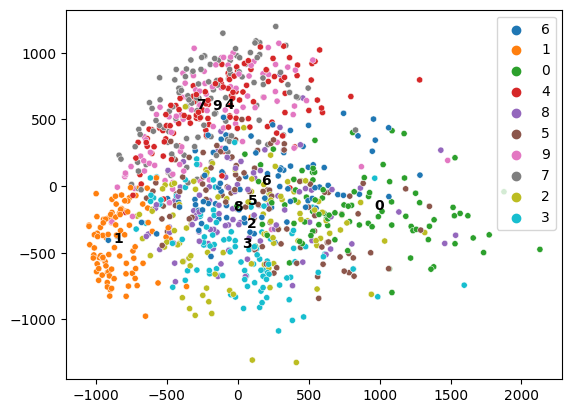

In [19]:
import seaborn as sns

b = EmbeddingsAnalysis(X_train, y_train, distance='cosine')
b.plot()

# Bubble Scatterplot
Without column labels, we will see a basic bubble scatterplot all the same color. (We could color it, but it will be confused with the next iteration.)

In [22]:
# Dimensionality reduction for plotting
# This is a noteworthy aspect -- we should consider keeping the transformation model from the raw data.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

<Axes: xlabel='x', ylabel='y'>

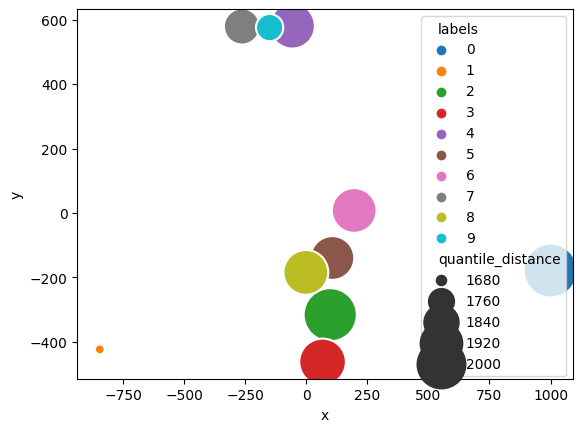

In [52]:
import pandas as pd
from whylogs_sketching import NO_FALSE_POSITIVES

bubble_data = pd.DataFrame(prod_profile_view.get_column(col_name="pixel_values") \
              .get_metric("embedding").submetrics["closest"]["frequent_items"] \
              .frequent_strings.value.get_frequent_items(err_type=NO_FALSE_POSITIVES), \
                  columns=["Count", "LB", "Estimate", "UB"])
bubble_data["labels"] = labels

radius_values = []
for lbl in labels:
    radius_values.append(prod_profile_view.get_column(col_name="pixel_values").get_metric("embedding")\
          .submetrics[f"{lbl}_closest_distance"]["distribution"].kll.value.get_quantiles([0.9])[0])
bubble_data["quantile_distance"] = radius_values

pca_refs = pca.transform(references)
bubble_data["x"] = pca_refs[:, 0]
bubble_data["y"] = pca_refs[:, 1]

# If we DON'T have reference data available, we'll see the bubbles one by one
sns.scatterplot(data=bubble_data, x="x", y="y", size="quantile_distance", hue="labels",
                legend=True, sizes=(50, 1500))

0 1000.2041546161977 -178.44086083959564 2076.3753380474936
1 -845.4230809908687 -423.0231275593871 1678.9837904814854
2 98.17895244518988 -315.68787218357994 2067.5804065632615
3 66.72281587317806 -461.94461355932793 1974.5617667800536
4 -57.10191810970756 580.4993391337783 1956.3298684104057
5 106.87087026871863 -139.40034916803532 1937.8679447848276
6 196.33268908104884 7.927035342397797 1949.525693430253
7 -263.1826625526879 578.7291398790059 1850.3974376580286
8 -1.6093481185820213 -184.14846035986375 1950.7546001789133
9 -149.93442200227173 575.3362961101259 1770.6442586675976


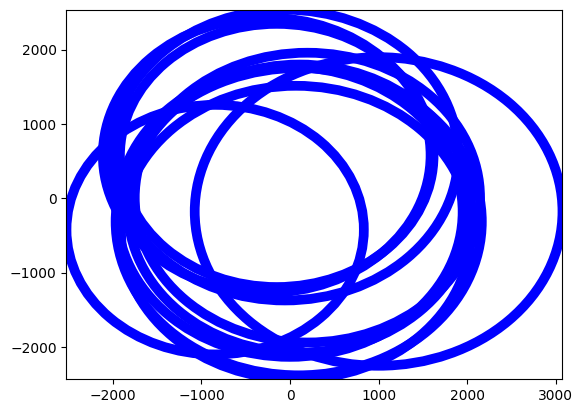

In [53]:
pca_refs = pca.transform(references)
bubble_data["x"] = pca_refs[:, 0]
bubble_data["y"] = pca_refs[:, 1]

# If we DON'T have reference data available, we'll see the bubbles one by one
fig, ax = plt.subplots()
xlim = [np.inf,-np.inf]
ylim = [np.inf,-np.inf]
for row in bubble_data.iterrows():
    x = row[1]["x"]
    y = row[1]["y"]
    radius = row[1]["quantile_distance"]
    label = row[1]["labels"]
    print(label, x, y, radius)
    ax.add_patch(plt.Circle((x, y), radius, edgecolor="b", linewidth=7, fill=False))
    if x - radius < xlim[0]: xlim[0] = x - radius
    if x + radius > xlim[1]: xlim[1] = x + radius
    if y - radius < ylim[0]: ylim[0] = y - radius
    if y + radius > ylim[1]: ylim[1] = y + radius

plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Heatmap with predictions (or actuals)

[Text(0.5, 23.52222222222222, 'Closest reference'),
 Text(50.722222222222214, 0.5, 'True label')]

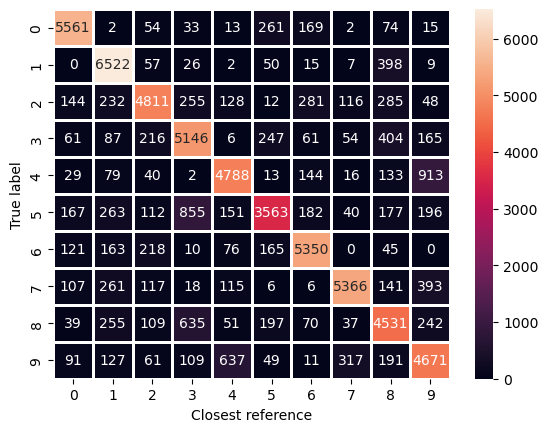

In [66]:
b.plot_closest_references_by_label()

# Circle packing Scatterplot

When we are able to multi-column, we'd like to pair the prediction with the embeddings. This is the most common analysis with this sort of chart.

In [20]:
bubble_data

,Count,LB,Estimate,UB,labels,x,y
0,3,722,722,722,0,1000.571535,-165.251253
1,9,717,717,717,1,-843.112977,-429.559778
2,4,712,712,712,2,100.893834,-317.527389
3,6,712,712,712,3,73.135841,-466.065509
4,7,688,688,688,4,-66.048099,577.900924
5,0,685,685,685,5,105.106282,-137.343912
6,1,680,680,680,6,195.601309,11.074862
7,2,596,596,596,7,-268.358069,578.886308
8,8,593,593,593,8,3.201129,-184.465095
9,5,551,551,551,9,-157.180648,573.032545


In [18]:
import circlify

In [60]:
(bubble_data.sort_values(by="Estimate", ascending=False)["Estimate"] * 5).tolist()

[3610, 3585, 3560, 3560, 3440, 3425, 3400, 2980, 2965, 2755]

[Circle(x=-0.772234810582928, y=-0.014676604888166416, r=0.22762573488813492, level=1, ex={'datum': 2755}), Circle(x=-0.5252758237236882, y=0.4551024501921103, r=0.23614182111624996, level=1, ex={'datum': 2965}), Circle(x=-0.5241405535865817, y=-0.4072110377015517, r=0.23673839087815923, level=1, ex={'datum': 2980}), Circle(x=-0.2933445378288352, y=0.02458882363345215, r=0.25287157750338635, level=1, ex={'datum': 3400}), Circle(x=-0.034258021898103334, y=-0.43256012657164045, r=0.2537995497136529, level=1, ex={'datum': 3425}), Circle(x=-0.03481455882934851, y=0.46098400536818745, r=0.25435470797752907, level=1, ex={'datum': 3440}), Circle(x=0.4782892576517624, y=0.4630074001048865, r=0.25875309805716906, level=1, ex={'datum': 3560}), Circle(x=0.4782892576517624, y=-0.4349059660616074, r=0.25875309805716906, level=1, ex={'datum': 3560}), Circle(x=0.21907874355519633, y=0.014050717021639531, r=0.2596600517599594, level=1, ex={'datum': 3585}), Circle(x=0.7393026439315489, y=0.014050717021

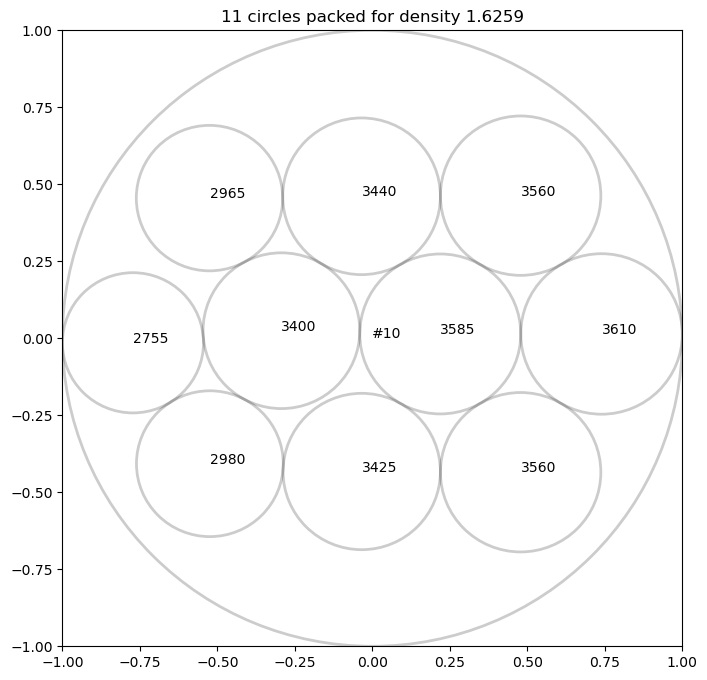

In [65]:
import circlify

circles = circlify.circlify(
    (bubble_data.sort_values(by="Estimate", ascending=False)["Estimate"] * 5).tolist(), 
    show_enclosure=True, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1))
print(circles)

labels = bubble_data.sort_values(by="Estimate", ascending=False)["labels"].tolist().append("")

circlify.bubbles(circles, labels=labels)